## Domain adaptation

In [42]:
import fasttext
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import scipy.stats
from nltk.tokenize import TweetTokenizer
from IPython.display import clear_output

In [2]:
DATADIR = "../data/"
DISTANCE = "distance"
FILEFASTTEXT = "fasttext.csv"
IDSTR = "id_str"
IRRELEVANT = "IRRELEVANT"
NEUTRAL = "NEUTRAL"
ANDERS = "ANDERS"
EENS = "EENS"
ONEENS = "ONEENS"
SUPPORTS = "SUPPORTS"
REJECTS = "REJECTS"
LABEL = "label"
TEXT = "text"
USER = "user"
LABELPREFIX = "__label__"
LARGEINT = 9999999999

In [3]:
DIM = 100
EPOCH = 100
LR = 0.05
N = 10
TRAIN = "TRAIN"+str(int(random.random()*LARGEINT))
TEST = "TEST"+str(int(random.random()*LARGEINT))
VALIDATION = "VALIDATION"+str(int(random.random()*LARGEINT))

In [4]:
def cleanup(text):
    text = re.sub(r"\\n"," ",text)
    text = re.sub(r"https://\S+","",text)
    text = re.sub(r"\s+"," ",text)
    text = text.strip()
    return(text)


def tokenize(text):
    return(" ".join(TweetTokenizer().tokenize(text)))


def preprocess(text):
    return(tokenize(cleanup(text)).lower())


def select_annotations(tweets, annotations, target_annotator):
    fasttext_data = {}
    for i in range(0,len(annotations)):
        annotator = annotations.iloc[i][0]
        tweet_id = annotations.iloc[i][2]
        if annotator == target_annotator and tweet_id in list(tweets.index):
            tweet_user = tweets.loc[tweet_id][1]
            tweet_label = annotations.iloc[i][4]
            if tweet_label == NEUTRAL: tweet_label = IRRELEVANT
            if tweet_label == ANDERS: tweet_label = IRRELEVANT
            if tweet_label == EENS: tweet_label = SUPPORTS
            if tweet_label == ONEENS: tweet_label = REJECTS
            fasttext_data[tweet_id] = { LABEL:LABELPREFIX+tweet_label,
                                        USER:tweet_user,
                                        TEXT:preprocess(tweets.loc[tweet_id][TEXT]) }
    return(fasttext_data)


def store_fasttext_data(fasttext_data):
    outfile = open(FILEFASTTEXT, "w")
    seen_texts = {}
    fasttext_data_list = []
    tweet_ids = []
    for tweet_id in fasttext_data:
        text = cleanup(fasttext_data[tweet_id][TEXT])
        if not text in seen_texts:
            print(fasttext_data[tweet_id][LABEL], text, file=outfile)
            fasttext_data_list.append(" ".join([fasttext_data[tweet_id][LABEL], text]))
            tweet_ids.append(tweet_id)
            seen_texts[text] = True
    outfile.close()
    return(fasttext_data_list, tweet_ids)

In [5]:
def make_fasttext_data(topic):
    if topic == DISTANCE:
        tweet_file = DATADIR + topic + "-tweets.csv"
    else:
        tweet_file = DATADIR + topic + "-tweets+nunl.csv"
    tweets = pd.read_csv(tweet_file, index_col=IDSTR)   
    annotations = pd.read_csv(tweet_file + ".human-labels.txt", header=None, sep=" ")        
    main_annotator = annotations.iloc[0][0]
    fasttext_data = select_annotations(tweets, annotations, main_annotator)
    fasttext_data_list, tweet_ids = store_fasttext_data(fasttext_data)
    return(fasttext_data_list, tweet_ids)

In [125]:
def makeConfusionMatrix(fasttextData,predictionLabels):
    goldLabels = pd.Series([fasttextData[i].split()[0] for i in range(0,len(fasttextData))])
    predictedLabels = pd.Series([x[0] for row in predictionLabels for x in row[0]])
    return(pd.crosstab(goldLabels,predictedLabels))

def evaluate(predictionCounts,predictionLabels,fasttextData,printResults=True,printMatrix=False):
    caseTotal = 0
    pTotal = 0
    rTotal = 0
    for i in range(0,len(predictionCounts)):
        caseTotal += predictionCounts[i][0]
        pTotal += predictionCounts[i][0]*predictionCounts[i][1]
        rTotal += predictionCounts[i][0]*predictionCounts[i][2]
    precision = round(pTotal/caseTotal,3)
    recall = round(rTotal/caseTotal,3)
    cf = makeConfusionMatrix(fasttextData,predictionLabels)
    if printMatrix:
        print(cf)
    for label in ['__label__REJECTS','__label__SUPPORTS','__label__IRRELEVANT']:
        if not label in cf: cf[label] = [0 for i in range(0,len(cf))]
    numberOfPredictedSupportLabels = sum([cf.iloc[i]['__label__SUPPORTS'] for i in range(0,len(cf))])
    numberOfGoldSupportLabels = sum(cf.loc['__label__SUPPORTS'])
    numberOfPredictedRejectLabels = sum([cf.iloc[i]['__label__REJECTS'] for i in range(0,len(cf))])
    numberOfGoldRejectLabels = sum(cf.loc['__label__REJECTS'])
    if numberOfPredictedSupportLabels > 0 and numberOfGoldRejectLabels > 0 and numberOfGoldSupportLabels > 0:
        fraction = (numberOfPredictedRejectLabels/numberOfPredictedSupportLabels)/(numberOfGoldRejectLabels/numberOfGoldSupportLabels)
    else:
        fraction = LARGEINT
    if printResults: 
        print("cases: {0}; precision: {1:0.3f}; recall: {2:0.3f}; fraction: {3:0.3f}".format(caseTotal,precision,recall,fraction))
    return((precision,fraction))

def runFasttext(fasttextData1,fasttextData2,dim=DIM,epoch=EPOCH,lr=LR,n=N,squealFlag=True,maxTrain=None,pretrainedVectors=None):
    predictionCountsTest = []
    predictionLabelsTest = []
    predictionCountsValidation = []
    predictionLabelsValidation = []
    for fold in range(0,n):
        if squealFlag:
            clear_output(wait=True)
            print("starting fold",fold)
        testStart1 = round(fold*len(fasttextData1)/n)
        testEnd1 = round((fold+1)*len(fasttextData1)/n)
        testStart2 = round(fold*len(fasttextData2)/n)
        testEnd2 = round((fold+1)*len(fasttextData2)/n)
        if fold < n-1: nextFold = fold+1
        else: nextFold = 0
        validationStart1 = round(nextFold*len(fasttextData1)/n)
        validationEnd1 = round((nextFold+1)*len(fasttextData1)/n)
        validationStart2 = round(nextFold*len(fasttextData2)/n)
        validationEnd2 = round((nextFold+1)*len(fasttextData2)/n)
        trainFile = open(TRAIN,"w")
        testFile = open(TEST,"w")
        validationFile = open(VALIDATION,"w")
        trainData = []
        validationData = []
        testData = []
        for i in range(0,len(fasttextData1)):
            data = fasttextData1[i]
            if i >= testStart1 and i < testEnd1: 
                pass
            elif i >= validationStart1 and i < validationEnd1: 
                pass
            else: 
                print(data,file=trainFile)
                trainData.append(data)
        for i in range(0,len(fasttextData2)):
            data = fasttextData2[i]
            if i >= testStart2 and i < testEnd2: 
                print(data,file=testFile)
                testData.append(data)
            elif i >= validationStart2 and i < validationEnd2: 
                print(data,file=validationFile)
                validationData.append(data)
        testFile.close()
        trainFile.close()
        validationFile.close()
        if not maxTrain == None and maxTrain < len(trainData):
            trainData = ranSelect(trainData,maxTrain)
            trainFile = open(TRAIN,"w")
            for i in range(0,len(trainData)):
                print(trainData[i],file=trainFile)
            trainFile.close()
        if pretrainedVectors == None:
            model = fasttext.train_supervised(TRAIN, dim=dim, epoch=epoch, lr=lr)
        else:
            model = fasttext.train_supervised(TRAIN, dim=dim, epoch=epoch, lr=lr, pretrainedVectors=pretrainedVectors)
        predictionCountsValidation.append([*model.test(VALIDATION)])
        predictionLabelsValidation.append(model.predict(validationData, k=3))
        predictionCountsTest.append([*model.test(TEST)])
        predictionLabelsTest.append(model.predict(testData, k=3))
        print(fold, end=" ")
        evaluate([[*model.test(TEST)]], [model.predict(testData)], fasttextData2[testStart2:testEnd2])
        os.unlink(TRAIN)
        os.unlink(TEST)
        os.unlink(VALIDATION)
    print("", end=" ")
    evaluate(predictionCountsTest, predictionLabelsTest, fasttextData2, printMatrix=True)
    if squealFlag:
        clear_output(wait=True)
        print("finished")
    return(predictionCountsValidation,predictionLabelsValidation,predictionCountsTest,predictionLabelsTest)

In [7]:
fasttext_data_list_distance, tweet_ids_distance = make_fasttext_data("distance")
fasttext_data_list_facemask, tweet_ids_facemask = make_fasttext_data("mondkapje")

## Evaluation within domains

In [8]:
predictionCountsValidationDD,predictionLabelsValidationDD,predictionCountsTestDD,predictionLabelsTestDD = \
    runFasttext(fasttext_data_list_distance, fasttext_data_list_distance, squealFlag=False, dim=300, pretrainedVectors="model-2020.vec")

0 cases: 573; precision: 0.691; recall: 0.691; fraction: 0.996
1 cases: 573; precision: 0.754; recall: 0.754; fraction: 1.188
2 cases: 573; precision: 0.557; recall: 0.557; fraction: 0.779
3 cases: 573; precision: 0.627; recall: 0.627; fraction: 1.177
4 cases: 574; precision: 0.618; recall: 0.618; fraction: 1.145
5 cases: 573; precision: 0.640; recall: 0.640; fraction: 0.741
6 cases: 573; precision: 0.656; recall: 0.656; fraction: 0.720
7 cases: 573; precision: 0.693; recall: 0.693; fraction: 0.758
8 cases: 573; precision: 0.667; recall: 0.667; fraction: 0.863
9 cases: 573; precision: 0.663; recall: 0.663; fraction: 1.002
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  574               203                590
__label__REJECTS                     198               641                297
__label__SUPPORTS                    433               24

In [21]:
predictionCountsValidationFF,predictionLabelsValidationFF,predictionCountsTestFF,predictionLabelsTestFF = \
    runFasttext(fasttext_data_list_facemask, fasttext_data_list_facemask, squealFlag=False, dim=300, pretrainedVectors="model-2020.vec")

0 cases: 132; precision: 0.674; recall: 0.674; fraction: 1.266
1 cases: 132; precision: 0.561; recall: 0.561; fraction: 0.829
2 cases: 133; precision: 0.602; recall: 0.602; fraction: 3.656
3 cases: 132; precision: 0.629; recall: 0.629; fraction: 2.941
4 cases: 132; precision: 0.576; recall: 0.576; fraction: 0.759
5 cases: 132; precision: 0.553; recall: 0.553; fraction: 1.485
6 cases: 132; precision: 0.530; recall: 0.530; fraction: 1.360
7 cases: 133; precision: 0.534; recall: 0.534; fraction: 1.042
8 cases: 132; precision: 0.485; recall: 0.485; fraction: 1.400
9 cases: 132; precision: 0.500; recall: 0.500; fraction: 2.209
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  305               182                 71
__label__REJECTS                     138               369                 42
__label__SUPPORTS                     66                7

In [233]:
predictionCountsValidation,predictionLabelsValidation,predictionCountsTest,predictionLabelsTest = \
    runFasttext(fasttext_data_list_facemask, fasttext_data_list_facemask, squealFlag=False, dim=300)

0 cases: 132; precision: 0.636; recall: 0.636; fraction: 3.975
1 cases: 132; precision: 0.583; recall: 0.583; fraction: 1.225
2 cases: 133; precision: 0.594; recall: 0.594; fraction: 6.048
3 cases: 132; precision: 0.629; recall: 0.629; fraction: 6.588
4 cases: 132; precision: 0.545; recall: 0.545; fraction: 1.324
5 cases: 132; precision: 0.530; recall: 0.530; fraction: 1.676
6 cases: 132; precision: 0.508; recall: 0.508; fraction: 1.672
7 cases: 133; precision: 0.549; recall: 0.549; fraction: 2.068
8 cases: 132; precision: 0.492; recall: 0.492; fraction: 2.274
9 cases: 132; precision: 0.455; recall: 0.455; fraction: 2.621
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  300               210                 48
__label__REJECTS                     146               374                 29
__label__SUPPORTS                     70                8

In [234]:
predictionCountsValidation,predictionLabelsValidation,predictionCountsTest,predictionLabelsTest = \
    runFasttext(fasttext_data_list_distance, fasttext_data_list_distance, squealFlag=False)

0 cases: 573; precision: 0.606; recall: 0.606; fraction: 1.160
1 cases: 573; precision: 0.750; recall: 0.750; fraction: 1.171
2 cases: 573; precision: 0.546; recall: 0.546; fraction: 0.712
3 cases: 573; precision: 0.625; recall: 0.625; fraction: 1.082
4 cases: 574; precision: 0.578; recall: 0.578; fraction: 0.953
5 cases: 573; precision: 0.614; recall: 0.614; fraction: 0.664
6 cases: 573; precision: 0.627; recall: 0.627; fraction: 0.587
7 cases: 573; precision: 0.667; recall: 0.667; fraction: 0.745
8 cases: 573; precision: 0.642; recall: 0.642; fraction: 0.722
9 cases: 573; precision: 0.627; recall: 0.627; fraction: 0.928
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  530               203                634
__label__REJECTS                     223               566                347
__label__SUPPORTS                    475               24

## Predicting social distancing with facemask data

In [11]:
def count_labels(fasttext_data_list):
    counts = {}
    for i in range(0, len(fasttext_data_list)):
        token_list = fasttext_data_list[i].split()
        if token_list[0] in counts:
            counts[token_list[0]] += 1
        else:
            counts[token_list[0]] = 1
    return(counts)


def swap_labels(fasttext_data_list_in):
    fasttext_data_list_out = []
    for i in range(0, len(fasttext_data_list_in)):
        token_list = fasttext_data_list_in[i].split()
        if token_list[0] == "__label__REJECTS":
            token_list[0] = "__label__SUPPORTS"
        elif token_list[0] == "__label__SUPPORTS":
            token_list[0] = "__label__REJECTS"
        fasttext_data_list_out.append(" ".join(token_list))
    return(fasttext_data_list_out)

In [12]:
predictionCountsValidationFD,predictionLabelsValidationFD,predictionCountsTestFD,predictionLabelsTestFD = \
    runFasttext(fasttext_data_list_facemask, fasttext_data_list_distance, squealFlag=False, dim=300)

0 cases: 573; precision: 0.290; recall: 0.290; fraction: 15.068
1 cases: 573; precision: 0.354; recall: 0.354; fraction: 9.619
2 cases: 573; precision: 0.333; recall: 0.333; fraction: 4.454
3 cases: 573; precision: 0.344; recall: 0.344; fraction: 5.831
4 cases: 574; precision: 0.315; recall: 0.315; fraction: 8.603
5 cases: 573; precision: 0.318; recall: 0.318; fraction: 5.324
6 cases: 573; precision: 0.309; recall: 0.309; fraction: 4.361
7 cases: 573; precision: 0.274; recall: 0.274; fraction: 7.672
8 cases: 573; precision: 0.271; recall: 0.271; fraction: 7.913
9 cases: 573; precision: 0.328; recall: 0.328; fraction: 8.488
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  781               414                172
__label__REJECTS                     641               425                 70
__label__SUPPORTS                   1515              11

In [179]:
predictionCountsValidationFD,predictionLabelsValidationFD,predictionCountsTestFD,predictionLabelsTestFD = \
    runFasttext(fasttext_data_list_facemask, fasttext_data_list_distance, squealFlag=False, dim=300, pretrainedVectors="model-2020.vec")

0 cases: 573; precision: 0.325; recall: 0.325; fraction: 10.573
1 cases: 573; precision: 0.389; recall: 0.389; fraction: 8.026
2 cases: 573; precision: 0.330; recall: 0.330; fraction: 3.347
3 cases: 573; precision: 0.375; recall: 0.375; fraction: 5.885
4 cases: 574; precision: 0.329; recall: 0.329; fraction: 9.480
5 cases: 573; precision: 0.337; recall: 0.337; fraction: 5.261
6 cases: 573; precision: 0.319; recall: 0.319; fraction: 4.859
7 cases: 573; precision: 0.277; recall: 0.277; fraction: 5.782
8 cases: 573; precision: 0.283; recall: 0.283; fraction: 7.348
9 cases: 573; precision: 0.354; recall: 0.354; fraction: 8.241
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  815               397                155
__label__REJECTS                     622               448                 66
__label__SUPPORTS                   1640               9

In [13]:
def convert(data):
    plot_data =[]
    for key in data:
        if re.search("^[0-9]+$", str(key)):
            support_count = 0
            reject_count = 0
            for label in data[key]:
                if label == "__label__SUPPORTS":
                    support_count += 1
                if label == "__label__REJECTS":
                    reject_count += 1
            if support_count+reject_count > 0:
                plot_data.append((int(key), support_count/(support_count+reject_count)))
    plot_data = [x for x in sorted(plot_data, key=lambda x:x[0])]
    return(plot_data)

In [38]:
def make_data_predicted(predictionLabelsTest, tweet_ids, time_factor=4):
    predicted = []
    for i in range(0, len(predictionLabelsTest)):
        for j in range(0, len(predictionLabelsTest[i][0])):
            predicted.append(predictionLabelsTest[i][0][j])
    data_predicted = {}
    for i in range(0, len(tweet_ids)):
        summary = str(tweet_ids[i])[0:time_factor]
        if summary not in data_predicted:
            data_predicted[summary] = []
        data_predicted[summary].append(predicted[i][0])
    return(data_predicted)

In [68]:
data_predicted_fd = make_data_predicted(predictionLabelsTestFD, tweet_ids_distance)
data_predicted_dd = make_data_predicted(predictionLabelsTestDD, tweet_ids_distance)

In [69]:
gold = []
for tweet in fasttext_data_list_distance:
    gold.append(tweet.split()[0])

data_gold = {}
for i in range(0, len(tweet_ids_distance)):
    summary = str(tweet_ids_distance[i])[0:4]
    if summary not in data_gold:
        data_gold[summary] = []
    data_gold[summary].append(gold[i])

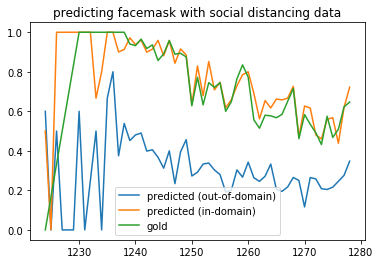

In [70]:
plot_data_predicted_fd = convert(data_predicted_fd)
plot_data_predicted_dd = convert(data_predicted_dd)
plot_data_gold = convert(data_gold)

x_gold = [x[0] for x in plot_data_gold]
y_gold = [x[1] for x in plot_data_gold]
x_fd = [x[0] for x in plot_data_predicted_fd]
y_fd = [x[1] for x in plot_data_predicted_fd]
x_dd = [x[0] for x in plot_data_predicted_dd]
y_dd = [x[1] for x in plot_data_predicted_dd]
plt.plot(x_fd, y_fd, label="predicted (out-of-domain)")
plt.plot(x_dd, y_dd, label="predicted (in-domain)")
plt.plot(x_gold, y_gold, label="gold")
plt.legend()
plt.title("predicting facemask with social distancing data")
plt.savefig("distancing-facemask.png")
plt.show()

In [83]:
plot_data_predicted_fd_dict = { x[0]:x[1] for x in plot_data_predicted_fd }
plot_data_predicted_dd_dict = { x[0]:x[1] for x in plot_data_predicted_dd }
plot_data_gold_dict = { x[0]:x[1] for x in plot_data_gold }

In [87]:
def get_common_key_values(dict1, dict2):
    values1 = []
    values2 = []
    for key in sorted(dict1.keys()):
        if key in dict2:
            values1.append(dict1[key])
            values2.append(dict2[key])
    return(values1, values2)

In [90]:
values_dd, values_gold_dd = get_common_key_values(plot_data_predicted_dd_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs in-domain:", round(scipy.stats.linregress(np.array(values_gold_dd), np.array(values_dd)).rvalue, 2))
values_fd, values_gold_fd = get_common_key_values(plot_data_predicted_fd_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs out-of-domain:", round(scipy.stats.linregress(np.array(values_gold_fd), np.array(values_fd)).rvalue, 2))

Pearson r correlation gold vs in-domain: 0.87
Pearson r correlation gold vs out-of-domain: 0.4


In [66]:
def absolute_difference(list1, list2):
    absolute_difference = 0
    for i in range(0, len(list1)):
        absolute_difference += abs(list1[i]-list2[i])
    return(absolute_difference/len(list1))

In [91]:
print("absolute difference gold vs in-domain:", round(absolute_difference(values_gold_dd, values_dd), 2))
print("absolute difference gold vs out-of-domain:", round(absolute_difference(values_gold_fd, values_fd),2)) 

absolute difference gold vs in-domain: 0.06
absolute difference gold vs out-of-domain: 0.42


## Predicting facemasks with social distancing data

In [17]:
predictionCountsValidationDF,predictionLabelsValidationDF,predictionCountsTestDF,predictionLabelsTestDF = \
    runFasttext(fasttext_data_list_distance, fasttext_data_list_facemask, squealFlag=False, dim=300)

0 cases: 132; precision: 0.508; recall: 0.508; fraction: 0.245
1 cases: 132; precision: 0.447; recall: 0.447; fraction: 0.219
2 cases: 133; precision: 0.398; recall: 0.398; fraction: 0.135
3 cases: 132; precision: 0.515; recall: 0.515; fraction: 0.110
4 cases: 132; precision: 0.356; recall: 0.356; fraction: 0.238
5 cases: 132; precision: 0.402; recall: 0.402; fraction: 0.145
6 cases: 132; precision: 0.356; recall: 0.356; fraction: 0.284
7 cases: 133; precision: 0.391; recall: 0.391; fraction: 0.227
8 cases: 132; precision: 0.379; recall: 0.379; fraction: 0.207
9 cases: 132; precision: 0.417; recall: 0.417; fraction: 0.385
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  208               144                206
__label__REJECTS                      93               205                251
__label__SUPPORTS                     37                4

In [178]:
predictionCountsValidationDF,predictionLabelsValidationDF,predictionCountsTestDF,predictionLabelsTestDF = \
    runFasttext(fasttext_data_list_distance, fasttext_data_list_facemask, squealFlag=False, dim=300, pretrainedVectors="model-2020.vec")

0 cases: 132; precision: 0.523; recall: 0.523; fraction: 0.259
1 cases: 132; precision: 0.394; recall: 0.394; fraction: 0.148
2 cases: 133; precision: 0.421; recall: 0.421; fraction: 0.150
3 cases: 132; precision: 0.508; recall: 0.508; fraction: 0.109
4 cases: 132; precision: 0.318; recall: 0.318; fraction: 0.234
5 cases: 132; precision: 0.402; recall: 0.402; fraction: 0.143
6 cases: 132; precision: 0.386; recall: 0.386; fraction: 0.251
7 cases: 133; precision: 0.368; recall: 0.368; fraction: 0.205
8 cases: 132; precision: 0.326; recall: 0.326; fraction: 0.173
9 cases: 132; precision: 0.424; recall: 0.424; fraction: 0.262
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  215               137                206
__label__REJECTS                     102               189                258
__label__SUPPORTS                     51                3

In [92]:
data_predicted_df = make_data_predicted(predictionLabelsTestDF, tweet_ids_facemask, time_factor=1)
data_predicted_ff = make_data_predicted(predictionLabelsTestFF, tweet_ids_facemask, time_factor=1)

In [93]:
gold = []
for tweet in fasttext_data_list_facemask:
    gold.append(tweet.split()[0])

data_gold = {}
for i in range(0, len(tweet_ids_facemask)):
    summary = str(tweet_ids_facemask[i])[0:1]
    if summary not in data_gold:
        data_gold[summary] = []
    data_gold[summary].append(gold[i])

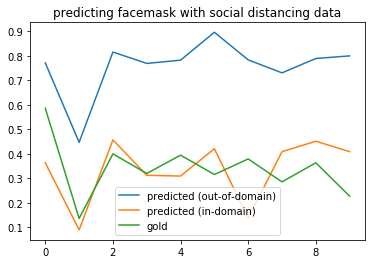

In [94]:
plot_data_predicted_df = convert(data_predicted_df)
plot_data_predicted_ff = convert(data_predicted_ff)
plot_data_gold = convert(data_gold)

x_gold = [x[0] for x in plot_data_gold]
y_gold = [x[1] for x in plot_data_gold]
x_df = [x[0] for x in plot_data_predicted_df]
y_df = [x[1] for x in plot_data_predicted_df]
x_ff = [x[0] for x in plot_data_predicted_ff]
y_ff = [x[1] for x in plot_data_predicted_ff]
plt.plot(x_df, y_df, label="predicted (out-of-domain)")
plt.plot(x_ff, y_ff, label="predicted (in-domain)")
plt.plot(x_gold, y_gold, label="gold")
plt.legend()
plt.title("predicting facemask with social distancing data")
plt.savefig("distancing-facemask.png")
plt.show()

In [95]:
plot_data_predicted_df_dict = { x[0]:x[1] for x in plot_data_predicted_df }
plot_data_predicted_ff_dict = { x[0]:x[1] for x in plot_data_predicted_ff }
plot_data_gold_dict = { x[0]:x[1] for x in plot_data_gold }

In [96]:
values_ff, values_gold_ff = get_common_key_values(plot_data_predicted_ff_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs in-domain:", round(scipy.stats.linregress(np.array(values_gold_ff), np.array(values_ff)).rvalue, 2))
values_df, values_gold_df = get_common_key_values(plot_data_predicted_df_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs out-of-domain:", round(scipy.stats.linregress(np.array(values_gold_df), np.array(values_df)).rvalue, 2))

Pearson r correlation gold vs in-domain: 0.32
Pearson r correlation gold vs out-of-domain: 0.53


In [97]:
print("absolute difference gold vs in-domain:", round(absolute_difference(values_gold_ff, values_ff), 2))
print("absolute difference gold vs out-of-domain:", round(absolute_difference(values_gold_df, values_df),2)) 

absolute difference gold vs in-domain: 0.12
absolute difference gold vs out-of-domain: 0.42


In [103]:
def get_freqs(label_list):
    freqs = {}
    for label in label_list:
        if label in freqs:
            freqs[label] += 1
        else:
            freqs[label] = 1
    for label in freqs:
        freqs[label] /= len(label_list)
    return(freqs)

In [113]:
print(get_freqs(gold))
print(get_freqs([y[0] for x in predictionLabelsTestFF for y in x[0]]))
print(get_freqs([y[0] for x in predictionLabelsTestDF for y in x[0]]))

{'__label__IRRELEVANT': 0.42208774583963693, '__label__REJECTS': 0.4152798789712557, '__label__SUPPORTS': 0.16263237518910742}
{'__label__IRRELEVANT': 0.38502269288956126, '__label__REJECTS': 0.4750378214826021, '__label__SUPPORTS': 0.13993948562783662}
{'__label__IRRELEVANT': 0.27760968229954613, '__label__REJECTS': 0.26777609682299547, '__label__SUPPORTS': 0.4546142208774584}


In [167]:
predictionCountsValidationF,predictionLabelsValidationF,predictionCountsTestF,predictionLabelsTestF = \
    runFasttext(fasttext_data_list_distance, fasttext_data_list_facemask, squealFlag=False, dim=300)

0 cases: 132; precision: 0.508; recall: 0.508; fraction: 0.245
1 cases: 132; precision: 0.439; recall: 0.439; fraction: 0.213
2 cases: 133; precision: 0.398; recall: 0.398; fraction: 0.135
3 cases: 132; precision: 0.500; recall: 0.500; fraction: 0.116
4 cases: 132; precision: 0.356; recall: 0.356; fraction: 0.238
5 cases: 132; precision: 0.402; recall: 0.402; fraction: 0.142
6 cases: 132; precision: 0.348; recall: 0.348; fraction: 0.264
7 cases: 133; precision: 0.391; recall: 0.391; fraction: 0.215
8 cases: 132; precision: 0.371; recall: 0.371; fraction: 0.192
9 cases: 132; precision: 0.409; recall: 0.409; fraction: 0.405
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  207               145                206
__label__REJECTS                      96               201                252
__label__SUPPORTS                     38                4

In [151]:
print(get_freqs([y[0] for x in predictionLabelsTestF for y in x[0]]))

{'__label__IRRELEVANT': 0.2586989409984871, '__label__REJECTS': 0.29122541603630864, '__label__SUPPORTS': 0.45007564296520425}


In [155]:
def inflate(predictionLabelsTestIn, source_label, target_label, factor):
    predictionLabelsTestOut = list(predictionLabelsTestIn)
    counter = 0
    for fold in predictionLabelsTestOut:
        for i in range(0, len(fold[0])):
            if fold[0][i][0] == target_label:
                for j in range(0, len(fold[0][i])):
                    if fold[0][i][j] == source_label:
                        break
                if fold[0][i][j] != source_label:
                    sys.exit("cannot happen")
                if fold[1][i][j]*factor > fold[1][i][0]:
                    fold[0][i][0], fold[0][i][j] = fold[0][i][j], fold[0][i][0]
    return(predictionLabelsTestOut)

In [156]:
freqs = get_freqs(gold)
print(freqs)
print(freqs['__label__REJECTS']/freqs['__label__SUPPORTS'])

{'__label__IRRELEVANT': 0.42208774583963693, '__label__REJECTS': 0.4152798789712557, '__label__SUPPORTS': 0.16263237518910742}
2.5534883720930233


In [175]:
FACTOR = 37

freqs = get_freqs([y[0] for x in inflate(predictionLabelsTestF, '__label__REJECTS', '__label__SUPPORTS', FACTOR) for y in x[0]])
print(freqs)
print(freqs['__label__REJECTS']/freqs['__label__SUPPORTS'])

{'__label__IRRELEVANT': 0.2579425113464448, '__label__REJECTS': 0.5347957639939486, '__label__SUPPORTS': 0.20726172465960666}
2.5802919708029197


In [176]:
data_predicted_f = make_data_predicted(inflate(predictionLabelsTestF, '__label__REJECTS', '__label__SUPPORTS', FACTOR), tweet_ids_facemask, time_factor=1)

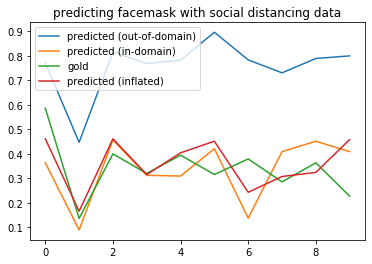

In [177]:
plot_data_predicted_df = convert(data_predicted_df)
plot_data_predicted_ff = convert(data_predicted_ff)
plot_data_predicted_f = convert(data_predicted_f)
plot_data_gold = convert(data_gold)

x_gold = [x[0] for x in plot_data_gold]
y_gold = [x[1] for x in plot_data_gold]
x_df = [x[0] for x in plot_data_predicted_df]
y_df = [x[1] for x in plot_data_predicted_df]
x_ff = [x[0] for x in plot_data_predicted_ff]
y_ff = [x[1] for x in plot_data_predicted_ff]
x_f = [x[0] for x in plot_data_predicted_f]
y_f = [x[1] for x in plot_data_predicted_f]
plt.plot(x_df, y_df, label="predicted (out-of-domain)")
plt.plot(x_ff, y_ff, label="predicted (in-domain)")
plt.plot(x_gold, y_gold, label="gold")
plt.plot(x_f, y_f, label="predicted (inflated)")
plt.legend()
plt.title("predicting facemask with social distancing data")
plt.savefig("distancing-facemask.png")
plt.show()